In [1]:
import os
import pandas as pd
import tensorflow as tf
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout, Bidirectional, Conv1D, GlobalMaxPooling1D, Concatenate, AdditiveAttention
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import AdditiveAttention
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from utils import eval, eval_training, get_train_test_data, save_for_evaluation, process_train_test_data
import re
import numpy as np
import spacy
from gensim.models import Word2Vec
from transformers import BertTokenizer, TFBertModel


os.environ['TF_NUM_INTEROP_THREADS'] = '10'
os.environ['TF_NUM_INTRAOP_THREADS'] = '10'

# Configure TensorFlow session for multi-threading
tf.config.threading.set_inter_op_parallelism_threads(10)
tf.config.threading.set_intra_op_parallelism_threads(10)
# Ensure TensorFlow is using the Metal backend
gpu = len (tf.config.list_physical_devices ('GPU'))>0
print ("GPU is", "available" if gpu else "NOT AVAILABLE")

GPU is available


# Data preparation

label
other-minor                 9805
meniskus-urgent             9312
cruciate-ligament-urgent    2388
meniskus-minor              1664
cruciate-ligament-minor      355
Name: count, dtype: int64


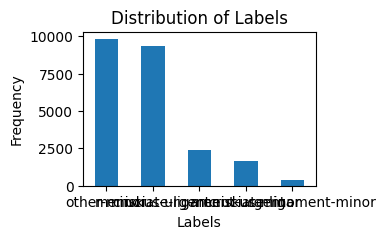

In [2]:
data_label = "data"
predict_label = "label"
balanced = False
labels = None
class_weights = False
sample_weights = False
df_train = pd.read_csv('../data/data_train.csv')
df_valid = pd.read_csv('../data/data_valid.csv')
df_test = pd.read_csv('../data/data_test.csv')

train_padded, valid_padded, test_padded, train_labels, valid_labels, test_labels, label_encoder, num_classes, max_length, word_index, class_weights, sample_weights = process_train_test_data(df_train, df_valid, df_test, data_label, predict_label, lables=labels, class_weights=class_weights, sample_weights=sample_weights)

# Model parameters

In [3]:
model_name = "l1_l2"

In [18]:
from utils import get_standard_parameters

optimizer, loss, metrics, early_stopping_callback, embedding_dim, lstm_units, epochs, batch_size = get_standard_parameters()

# Model definition and training

In [19]:
from tensorflow.keras.regularizers import l1_l2

# Define the input layer
input_text = Input(shape=(max_length,), dtype='int32', name='text_input')

# Embedding layer
embedding = Embedding(input_dim=len(word_index), output_dim=embedding_dim)(input_text)

# Two LSTM layers with L1 and L2 regularization
x = Bidirectional(LSTM(units=lstm_units, return_sequences=True, kernel_regularizer=l1_l2(0.0005, 0.0005)))(embedding)
x = Bidirectional(LSTM(units=lstm_units, kernel_regularizer=l1_l2(0.0005, 0.0005)))(x)

# Output layer
output = Dense(num_classes, activation='softmax', kernel_regularizer=l1_l2(0.0005, 0.0005))(x)

# Define the model
model = Model(inputs=input_text, outputs=output)

# Compile the model
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [20]:
history = model.fit(train_padded, train_labels, epochs=epochs, batch_size=batch_size,
                    validation_data=(valid_padded, valid_labels), callbacks=[early_stopping_callback])

Epoch 1/15
736/736 ━━━━━━━━━━━━━━━━━━━━ 151s 200ms/step - accuracy: 0.4218 - auc: 0.7963 - f1_score: 0.2262 - loss: 2.5942 - val_accuracy: 0.4645 - val_auc: 0.8274 - val_f1_score: 0.2042 - val_loss: 1.1639
Epoch 2/15
736/736 ━━━━━━━━━━━━━━━━━━━━ 145s 197ms/step - accuracy: 0.5136 - auc: 0.8423 - f1_score: 0.2948 - loss: 1.1287 - val_accuracy: 0.5348 - val_auc: 0.8480 - val_f1_score: 0.3175 - val_loss: 1.1231
Epoch 3/15
736/736 ━━━━━━━━━━━━━━━━━━━━ 145s 197ms/step - accuracy: 0.5968 - auc: 0.8689 - f1_score: 0.3584 - loss: 1.0585 - val_accuracy: 0.5607 - val_auc: 0.8556 - val_f1_score: 0.2712 - val_loss: 1.1181
Epoch 4/15
736/736 ━━━━━━━━━━━━━━━━━━━━ 146s 198ms/step - accuracy: 0.6444 - auc: 0.8880 - f1_score: 0.3926 - loss: 0.9892 - val_accuracy: 0.5740 - val_auc: 0.8612 - val_f1_score: 0.3444 - val_loss: 1.1066
Epoch 5/15
736/736 ━━━━━━━━━━━━━━━━━━━━ 118s 160ms/step - accuracy: 0.6744 - auc: 0.9029 - f1_score: 0.4065 - loss: 0.9283 - val_accuracy: 0.5976 - val_auc: 0.8678 - val_f1_sco

In [ ]:
save_for_evaluation(model, history, model_name, test_padded, test_labels, label_encoder)

Model saved to models/l1_l2/l1_l2.h5
Data saved


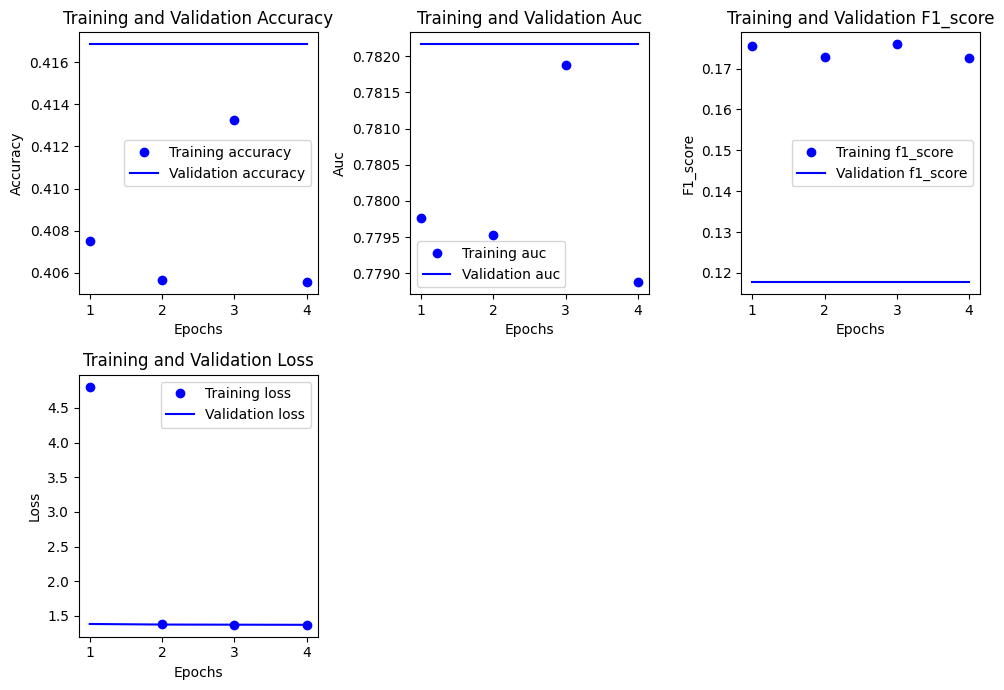

In [ ]:
eval_training(history, metrics)

246/246 ━━━━━━━━━━━━━━━━━━━━ 16s 63ms/step


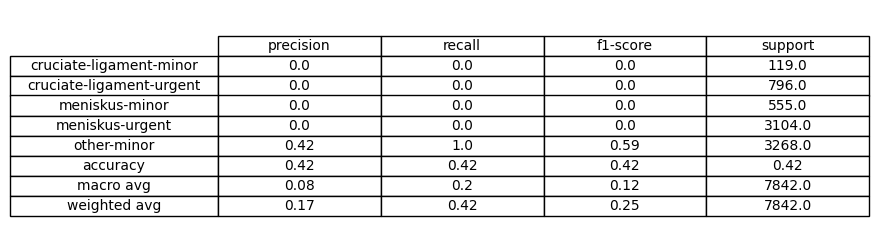

In [ ]:
eval(model, test_padded, test_labels, label_encoder)

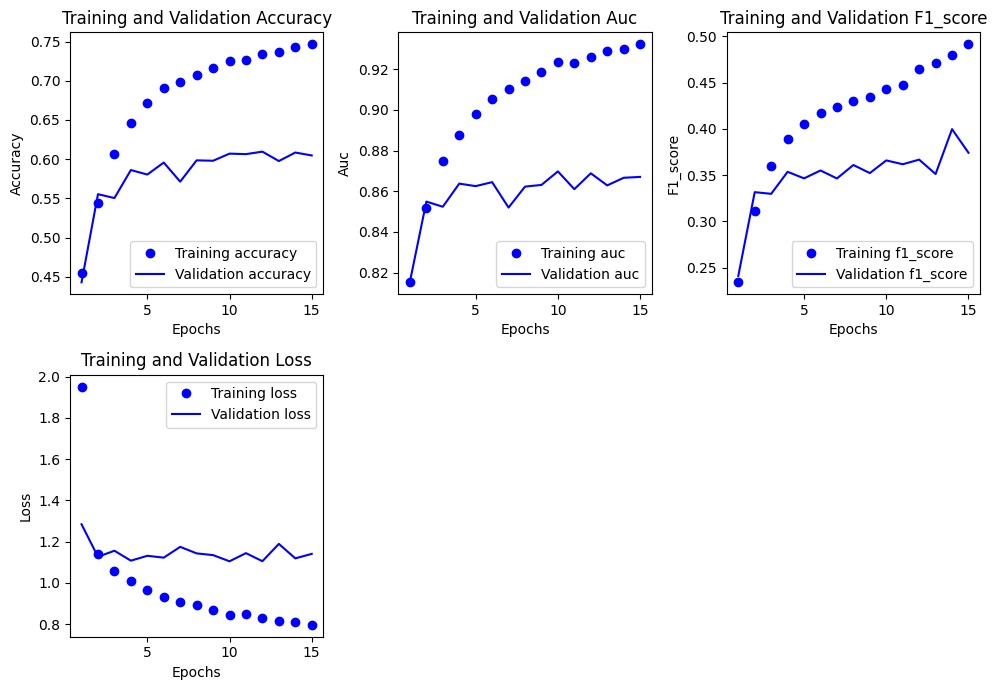

In [11]:
eval_training(history, metrics)

246/246 ━━━━━━━━━━━━━━━━━━━━ 16s 63ms/step


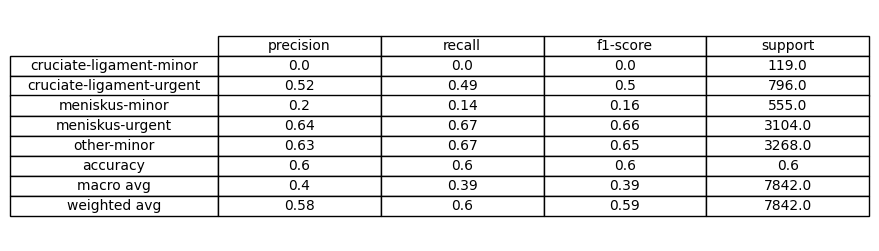

In [9]:
eval(model, test_padded, test_labels, label_encoder)